In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from transformers import set_seed

In [ ]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")

In [ ]:
X_train, y_train = train["clean_text"], train["HATEFUL"]
X_test, y_test = test["clean_text"], test["HATEFUL"]

In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [ ]:
tokenizer("Hola me llamo Airam",truncation=True,
            padding='max_length',
            max_length= 40,
            return_tensors='pt')

{'input_ids': tensor([[   4, 1734, 1094, 5592, 8971, 1062,    5,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=40):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
train_dataset = HateSpeechDataset(X_train, y_train, tokenizer)
val_dataset = HateSpeechDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
device

device(type='cuda')

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 5  # 3 épocas
)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc='Entrenando'):
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions, true_labels, all_logits = [], [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluando'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            preds = outputs.logits.argmax(dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    all_logits = np.array(all_logits)[:,1]
    auc = roc_auc_score(true_labels, all_logits, multi_class='ovr', average='macro')

    return accuracy, report, auc, predictions, true_labels

In [ ]:
set_seed(42)
for epoch in range(5):
    print(f'\nEpoch {epoch + 1}/5')
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_accuracy, val_report, auc, _ ,_ = evaluate(model, val_loader, device)
    print(f'Train Loss: {train_loss:.2f}, Validation Accuracy: {val_accuracy:.2f}, AUC: {auc:.2f}')
    print(val_report)

    if auc > 0.86:
      print(f"\n Tenemos un AUC suficiente de {auc:.2f}")
      break


Epoch 1/5


Evaluando: 100%|██████████| 666/666 [00:27<00:00, 24.54it/s]


Train Loss: 0.33, Validation Accuracy: 0.89, AUC: 0.86
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      8961
           1       0.73      0.51      0.60      1682

    accuracy                           0.89     10643
   macro avg       0.82      0.74      0.77     10643
weighted avg       0.88      0.89      0.89     10643


Epoch 2/5


Evaluando: 100%|██████████| 666/666 [00:27<00:00, 24.52it/s]

Train Loss: 0.24, Validation Accuracy: 0.88, AUC: 0.86
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8961
           1       0.63      0.61      0.62      1682

    accuracy                           0.88     10643
   macro avg       0.78      0.77      0.77     10643
weighted avg       0.88      0.88      0.88     10643


 Tenemos un AUC suficiente de 0.86


In [ ]:
auc

np.float64(0.8647025868869475)

In [ ]:
train_acc, train_report, auc_train, _ , _ = evaluate(model, train_loader, device)
print(f'Train acc: {train_acc:.2f}, Train report: {train_report}, Train AUC: {auc_train:.2f}')

Evaluando: 100%|██████████| 2103/2103 [01:26<00:00, 24.41it/s]


Train acc: 0.95, Train report:               precision    recall  f1-score   support

           0       0.97      0.97      0.97     28462
           1       0.85      0.85      0.85      5178

    accuracy                           0.95     33640
   macro avg       0.91      0.91      0.91     33640
weighted avg       0.95      0.95      0.95     33640
, Train AUC: 0.98


Evaluando: 100%|██████████| 666/666 [00:27<00:00, 24.52it/s]


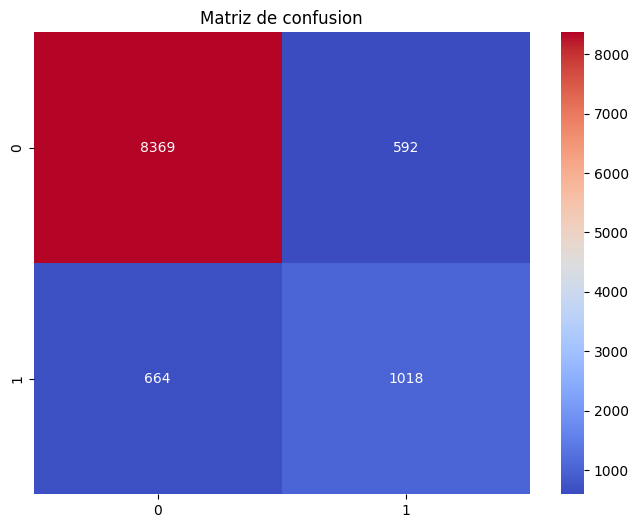

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
_, _, _, y_pred, y_true = evaluate(model, val_loader, device)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.title("Matriz de confusion")
sns.heatmap(cm, annot=True, fmt = "d", cmap="coolwarm")
plt.show()